In [2]:
import os
import pickle
import sys

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import tqdm
from torch.nn import functional as fnn
from torch.utils import data
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [8]:
PROJECT_PATH = ''

DATA_PATH = os.path.join(PROJECT_PATH, "data")

In [10]:
import random

np.random.seed(1234)
torch.manual_seed(1234)

TRAIN_SIZE = 0.8
NUM_PTS = 971
CROP_SIZE = 128
SUBMISSION_HEADER = "file_name,Point_M0_X,Point_M0_Y,Point_M1_X,Point_M1_Y,Point_M2_X,Point_M2_Y,Point_M3_X,Point_M3_Y,Point_M4_X,Point_M4_Y,Point_M5_X,Point_M5_Y,Point_M6_X,Point_M6_Y,Point_M7_X,Point_M7_Y,Point_M8_X,Point_M8_Y,Point_M9_X,Point_M9_Y,Point_M10_X,Point_M10_Y,Point_M11_X,Point_M11_Y,Point_M12_X,Point_M12_Y,Point_M13_X,Point_M13_Y,Point_M14_X,Point_M14_Y,Point_M15_X,Point_M15_Y,Point_M16_X,Point_M16_Y,Point_M17_X,Point_M17_Y,Point_M18_X,Point_M18_Y,Point_M19_X,Point_M19_Y,Point_M20_X,Point_M20_Y,Point_M21_X,Point_M21_Y,Point_M22_X,Point_M22_Y,Point_M23_X,Point_M23_Y,Point_M24_X,Point_M24_Y,Point_M25_X,Point_M25_Y,Point_M26_X,Point_M26_Y,Point_M27_X,Point_M27_Y,Point_M28_X,Point_M28_Y,Point_M29_X,Point_M29_Y\n"


class ScaleMinSideToSize(object):
    def __init__(self, size=(CROP_SIZE, CROP_SIZE), elem_name='image'):
        self.size = torch.tensor(size, dtype=torch.float)
        self.elem_name = elem_name

    def __call__(self, sample):
        h, w, _ = sample[self.elem_name].shape
        if h > w:
            f = self.size[0] / w
        else:
            f = self.size[1] / h

        sample[self.elem_name] = cv2.resize(sample[self.elem_name], None, fx=f, fy=f, interpolation=cv2.INTER_AREA)
        sample["scale_coef"] = f

        if 'landmarks' in sample:
            landmarks = sample['landmarks'].reshape(-1, 2).float()
            landmarks = landmarks * f
            sample['landmarks'] = landmarks.reshape(-1)

        return sample


class CropCenter(object):
    def __init__(self, size=128, elem_name='image'):
        self.size = size
        self.elem_name = elem_name

    def __call__(self, sample):
        img = sample[self.elem_name]
        h, w, _ = img.shape
        margin_h = (h - self.size) // 2
        margin_w = (w - self.size) // 2
        sample[self.elem_name] = img[margin_h:margin_h + self.size, margin_w:margin_w + self.size]
        sample["crop_margin_x"] = margin_w
        sample["crop_margin_y"] = margin_h

        if 'landmarks' in sample:
            landmarks = sample['landmarks'].reshape(-1, 2)
            landmarks -= torch.tensor((margin_w, margin_h), dtype=landmarks.dtype)[None, :]
            sample['landmarks'] = landmarks.reshape(-1)

        return sample

class TransformByKeys(object):
    def __init__(self, transform, names):
        self.transform = transform
        self.names = set(names)

    def __call__(self, sample):
        for name in self.names:
            if name in sample:
                sample[name] = self.transform(sample[name])

        return sample


class ThousandLandmarksDataset(data.Dataset):
    def __init__(self, root, transforms, split="train"):
        super(ThousandLandmarksDataset, self).__init__()
        self.root = root
        landmark_file_name = os.path.join(root, 'landmarks.csv') if split is not "test" \
            else os.path.join(root, "test_points.csv")
        images_root = os.path.join(root, "images")

        self.image_names = []
        self.landmarks = []

        dir_images_names = os.listdir(images_root)

        with open(landmark_file_name, "rt") as fp:
            num_lines = sum(1 for line in fp)
        num_lines -= 1  # header

        counter = 0

        with open(landmark_file_name, "rt") as fp:
            for i, line in tqdm.tqdm(enumerate(fp)):
                if i == 0:
                    continue  

                elements = line.strip().split("\t")
                
                # # print(elements[0])

                if elements[0] not in dir_images_names:
                    # print(elements[0])
                    continue

                counter += 1

                if split == "val" and counter % 5 != 1 and split != 'all': # int(TRAIN_SIZE * num_lines):
                    continue

                if split == "train" and counter % 5 == 1 and split != 'all': # int(TRAIN_SIZE * num_lines):
                    continue 

                image_name = os.path.join(images_root, elements[0])
                self.image_names.append(image_name)

                if split in ("train", "val"):
                    landmarks = list(map(np.int16, elements[1:]))
                    landmarks = np.array(landmarks, dtype=np.int16).reshape((len(landmarks) // 2, 2))
                    self.landmarks.append(landmarks)

        if split in ("train", "val", 'all'):
            self.landmarks = torch.as_tensor(self.landmarks)
        else:
            self.landmarks = None

        self.transforms = transforms

    def __getitem__(self, idx):
        sample = {}
        if self.landmarks is not None:
            landmarks = self.landmarks[idx]
            sample["landmarks"] = landmarks

        image = cv2.imread(self.image_names[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        sample["image"] = image

        if self.transforms is not None:
            sample = self.transforms(sample)

        return sample

    def __len__(self):
        return len(self.image_names)


def restore_landmarks(landmarks, f, margins):
    dx, dy = margins
    landmarks[:, 0] += dx
    landmarks[:, 1] += dy
    landmarks /= f
    return landmarks


def restore_landmarks_batch(landmarks, fs, margins_x, margins_y):
    landmarks[:, :, 0] += margins_x[:, None]
    landmarks[:, :, 1] += margins_y[:, None]
    landmarks /= fs[:, None, None]
    return landmarks


def create_submission(path_to_data, test_predictions, path_to_submission_file):
    test_dir = os.path.join(path_to_data, "test")

    output_file = path_to_submission_file
    wf = open(output_file, 'w')
    wf.write(SUBMISSION_HEADER)

    mapping_path = os.path.join(test_dir, 'test_points.csv')
    mapping = pd.read_csv(mapping_path, delimiter='\t')

    for i, row in mapping.iterrows():
        file_name = row[0]
        point_index_list = np.array(eval(row[1]))
        points_for_image = test_predictions[i]
        needed_points = points_for_image[point_index_list].astype(np.int)
        wf.write(file_name + ',' + ','.join(map(str, needed_points.reshape(2 * len(point_index_list)))) + '\n')


In [11]:
class RandomHorizontalFlip(object):
    def __init__(self, prob_to_flip=0.5, elem_name='image'):
        self.prob_to_flip = prob_to_flip
        self.elem_name = elem_name

    def __call__(self, sample):
        if random.random() > self.prob_to_flip:
            sample["is_flipped"] = False
            if 'landmarks' in sample:

                sample['landmarks'] = sample['landmarks'].reshape(-1)
            return sample
        
        img = sample[self.elem_name]
        img = cv2.flip( img, 1 )
        sample[self.elem_name] = img

        h, w, _ = img.shape

        sample["is_flipped"] = True

        if 'landmarks' in sample:
            landmarks = sample['landmarks'].reshape(-1)
            x = landmarks[::2]
            y = landmarks[1::2]

            flipped_x = torch.full_like(x, fill_value=w) - x
            flipped_landmarks = torch.stack([flipped_x, y], axis=1)

            sample['landmarks'] = flipped_landmarks.reshape(-1)
        
        return sample
    
class AddNoise(object):
    def __init__(self, prob_to_add_noise=0.5, elem_name='image'):
        self.prob_to_add_noise = prob_to_add_noise
        self.elem_name = elem_name

    def __call__(self, sample):
        if random.random() > self.prob_to_add_noise:
            sample["with_noise"] = False
            if 'landmarks' in sample:
                sample['landmarks'] = sample['landmarks'].reshape(-1)
            return sample
        
        img = sample[self.elem_name]
        h, w, c = img.shape
        noise = 0.005*np.random.randn(h, w, c)
        noisy_image = img + noise
        sample[self.elem_name] = noisy_image

        sample["with_noise"] = True

        if 'landmarks' in sample:
            sample['landmarks'] = sample['landmarks'].reshape(-1)
        
        return sample

In [12]:
def draw_landmarks(image, landmarks):
    for point in landmarks:
        x, y = point.astype(np.int)
        cv2.circle(image, (x, y), 1, (128, 0, 128), 1, -1)
    return image

from copy import deepcopy

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        new_tensor = deepcopy(tensor)
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [13]:
means = [0.5, 0.5, 0.5] #[0.485, 0.456, 0.406]
stds = [0.5, 0.5, 0.5] #[0.229, 0.224, 0.225]

In [14]:
def plot_results(dataloader, model, means=means, stds=means):
    batch = iter(dataloader).next()

    images = batch["image"].to(device)

    with torch.no_grad():
        pred_landmarks = model(images).cpu()

    images = UnNormalize(mean=means, std=stds)(images)
    images = images.cpu()

    if 'landmarks' in batch.keys():
        true_landmarks = batch["landmarks"]

        plt.figure(figsize=(23,8))

        image_count = 1

        for ind in range(4):
            plt.subplot(2,6, image_count)
            plt.title('Original')
            image = torch.clamp(np.transpose(images[ind], (1, 2, 0)), 0, 225).numpy()
            # image = (image * 255).astype(np.uint8)
            plt.imshow(image)
            image_count+=1

            plt.subplot(2,6, image_count)
            plt.title('True')
            lmk = true_landmarks[ind].reshape(-1, 2).float().numpy()
            plt.scatter([coord[0] for coord in lmk], [coord[1] for coord in lmk], c='g')            
            plt.imshow(image)
            image_count+=1


            plt.subplot(2,6, image_count)
            plt.title('Predicted')
            lmk = pred_landmarks[ind].reshape(-1, 2).float().numpy()
            plt.scatter([coord[0] for coord in lmk], [coord[1] for coord in lmk])            
            plt.imshow(image)
            image_count+=1
        plt.show()
    else:

        plt.figure(figsize=(15,8))

        image_count = 1

        for ind in range(4):
            plt.subplot(2,4, image_count)
            plt.title('Original')
            image = torch.clamp(np.transpose(images[ind], (1, 2, 0)), 0, 255).numpy()
            # image = (image * 255).astype(np.uint8)
            plt.imshow(image)
            image_count+=1

            plt.subplot(2,4, image_count)
            plt.title('Predicted')
            lmk = pred_landmarks[ind].reshape(-1, 2).float().numpy()
            plt.scatter([coord[0] for coord in lmk], [coord[1] for coord in lmk])
            plt.imshow(image)
            image_count+=1
        plt.show()

In [15]:
def train(model, loader, loss_fn, optimizer, device):
    model.train()
    train_loss = []
    for batch in tqdm.tqdm(loader, total=len(loader), desc="training..."):
        images = batch["image"].to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
        landmarks = batch["landmarks"]  # B x (2 * NUM_PTS)

        pred_landmarks = model(images).cpu()  # B x (2 * NUM_PTS)
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return np.mean(train_loss)


def validate(model, loader, loss_fn, device):
    model.eval()
    val_loss = []
    for batch in tqdm.tqdm(loader, total=len(loader), desc="validation..."):
        images = batch["image"].to(device)
        landmarks = batch["landmarks"]

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        val_loss.append(loss.item())

    return np.mean(val_loss)


def predict(model, loader, device):
    model.eval()
    predictions = np.zeros((len(loader.dataset), NUM_PTS, 2))
    for i, batch in enumerate(tqdm.tqdm(loader, total=len(loader), desc="test prediction...")):
        images = batch["image"].to(device)

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        pred_landmarks = pred_landmarks.numpy().reshape((len(pred_landmarks), NUM_PTS, 2))  # B x NUM_PTS x 2

        fs = batch["scale_coef"].numpy()  # B
        margins_x = batch["crop_margin_x"].numpy()  # B
        margins_y = batch["crop_margin_y"].numpy()  # B
        prediction = restore_landmarks_batch(pred_landmarks, fs, margins_x, margins_y)  # B x NUM_PTS x 2
        predictions[i * loader.batch_size: (i + 1) * loader.batch_size] = prediction

    return predictions

In [ ]:
def create_submission(path_to_data, test_predictions, path_to_submission_file):
    test_dir = os.path.join(path_to_data, "test")

    output_file = path_to_submission_file
    wf = open(output_file, 'w')
    wf.write(SUBMISSION_HEADER)

    mapping_path = os.path.join(test_dir, 'test_points.csv')
    mapping = pd.read_csv(mapping_path, delimiter='\t')

    for i, row in mapping.iterrows():
        file_name = row[0]
        point_index_list = np.array(eval(row[1]))
        points_for_image = test_predictions[i]
        needed_points = points_for_image[point_index_list].astype(np.int)
        wf.write(file_name + ',' + ','.join(map(str, needed_points.reshape(2 * len(point_index_list)))) + '\n')

In [16]:
batch_size = 128
learning_rate = 0.001
epochs = 10
name = os.path.join(DATA_PATH,'submit')

In [17]:
# 1. prepare data & models
means = [0.5, 0.5, 0.5] #[0.485, 0.456, 0.406]
stds = [0.5, 0.5, 0.5] #[0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
        # AddNoise(0.5),
        # RandomHorizontalFlip(0),
        ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
        CropCenter(CROP_SIZE),
        TransformByKeys(transforms.ToPILImage(), ("image",)),
#         TransformByKeys(transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), ("image",)),
        TransformByKeys(transforms.ToTensor(), ("image",)),
        TransformByKeys(transforms.Normalize(mean=means, std=stds), ("image",)),
    ])

# 1. prepare data & models
test_transforms = transforms.Compose([
        ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
        CropCenter(CROP_SIZE),
        TransformByKeys(transforms.ToPILImage(), ("image",)),
        TransformByKeys(transforms.ToTensor(), ("image",)),
        TransformByKeys(transforms.Normalize(mean=means, std=stds), ("image",)),
    ])

In [18]:
print("Reading data...")
train_dataset = ThousandLandmarksDataset(os.path.join(DATA_PATH, 'train'), train_transforms, split="train")
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, num_workers=4, pin_memory=True,
                                       shuffle=True, drop_last=True)


Reading data...


393931it [23:34, 278.45it/s]


In [19]:
len(train_dataloader), len(train_dataset.image_names)

(2462, 315144)

In [20]:
val_dataset = ThousandLandmarksDataset(os.path.join(DATA_PATH, 'train'), train_transforms, split="val")
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, num_workers=4, pin_memory=True,
                                     shuffle=False, drop_last=False)

393931it [20:16, 323.94it/s]


In [21]:
len(val_dataloader), len(val_dataset.image_names)

(616, 78786)

In [22]:
print("Creating model...")
N_HIDDEN = 1024

device = torch.device("cuda: 0") if torch.cuda.is_available() else torch.device("cpu")
model = models.resnet101(pretrained=True)

print(model.fc.in_features)

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, N_HIDDEN), 
    # nn.BatchNorm1d(N_HIDDEN),
#     nn.LeakyReLU(),
    nn.Linear(N_HIDDEN, 2 * NUM_PTS, bias=True)
    )
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)
loss_fn = fnn.mse_loss

Creating model...
2048


In [23]:
test_dataset = ThousandLandmarksDataset(os.path.join(DATA_PATH, 'test'), test_transforms, split="test")
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, num_workers=4, pin_memory=True,
                                      shuffle=False, drop_last=False)

len(test_dataloader), len(test_dataset.image_names)

99820it [01:08, 1452.55it/s]


(780, 99819)

In [24]:
np.random.seed(1234)

NUM_IMAGES_TO_SHOW = 4
NUM_COLS = 4
NUM_ROWS = 1 

training...:   0%|          | 0/2462 [00:00<?, ?it/s]

Ready for training...
Epoch 0----------------------------------------------


validation...: 100%|██████████| 616/616 [02:20<00:00,  4.38it/s]

Epoch # 0:	train loss: 2.2e+01	val loss:   5.6


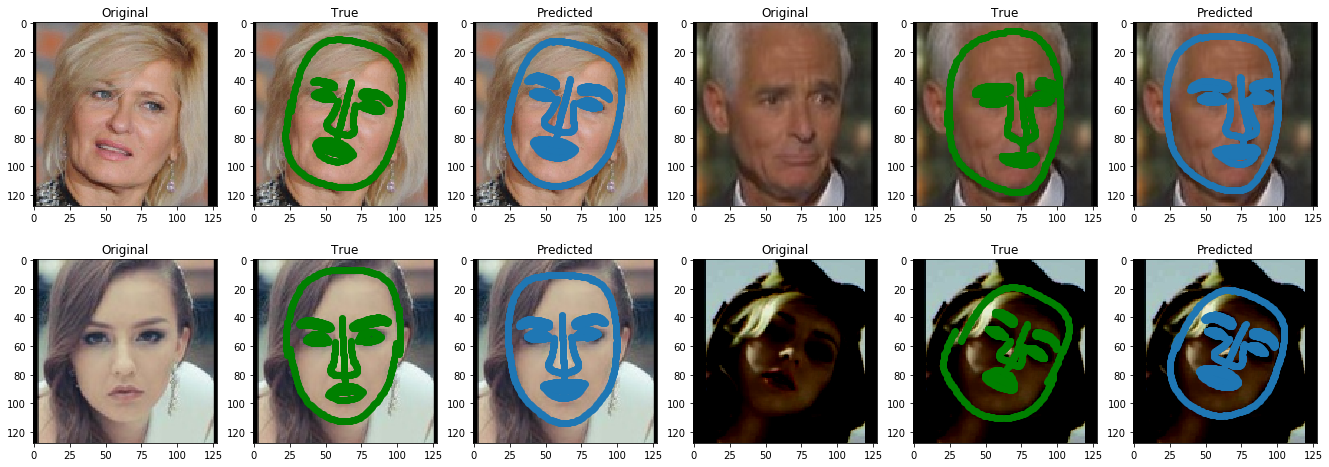

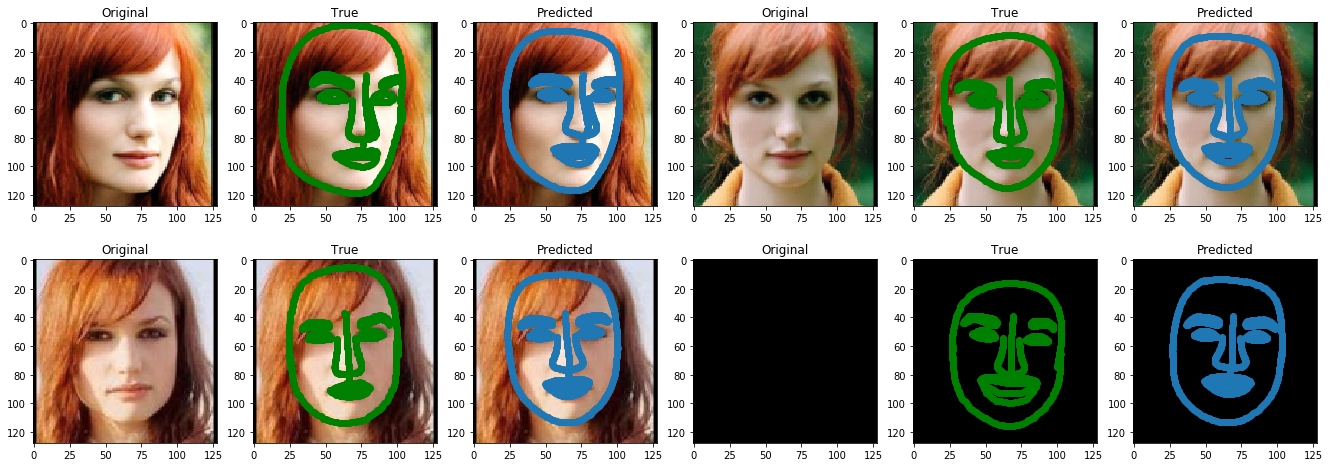

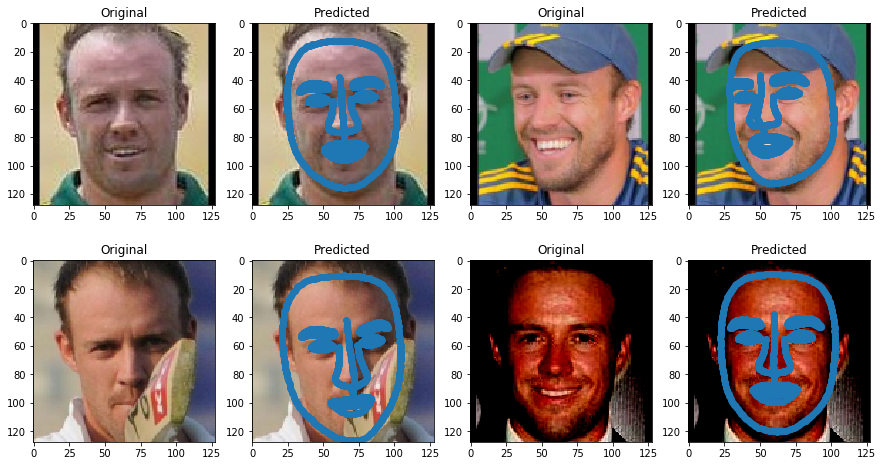

training...:   0%|          | 0/2462 [00:00<?, ?it/s]

Epoch 1----------------------------------------------


validation...: 100%|██████████| 616/616 [02:20<00:00,  4.38it/s]

Epoch # 1:	train loss:   4.2	val loss:   3.4


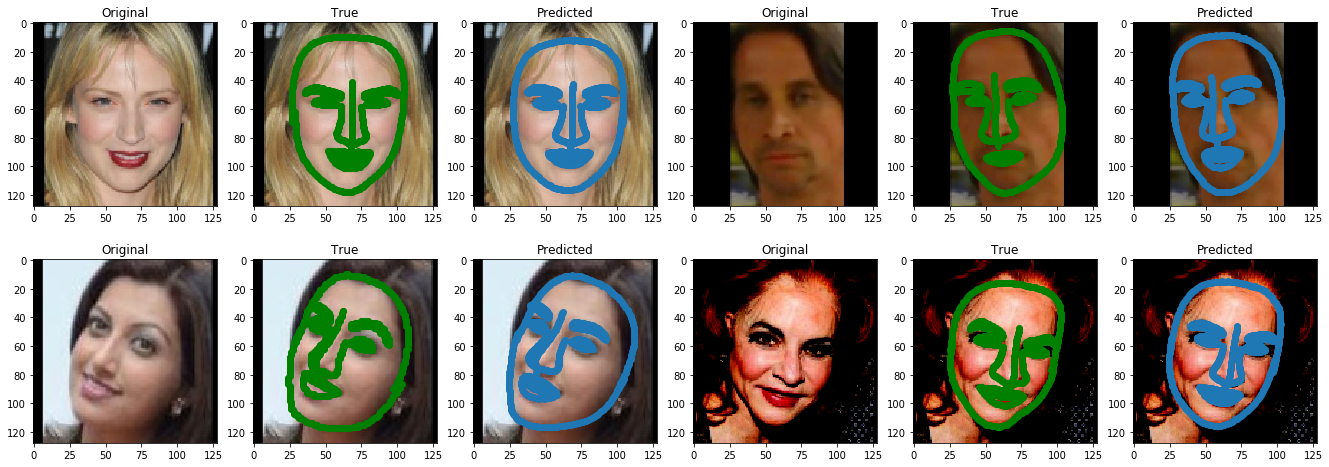

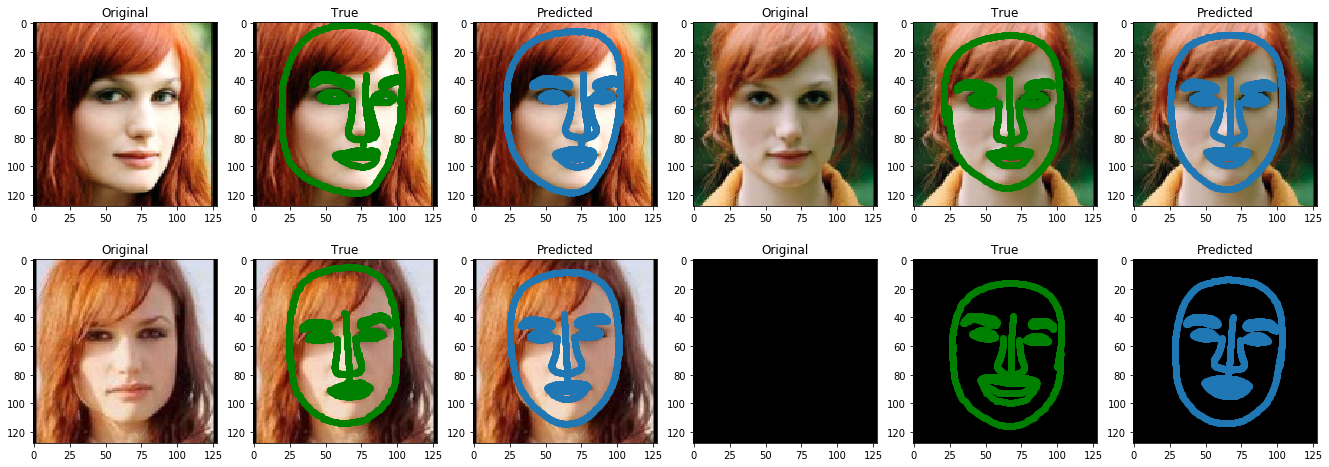

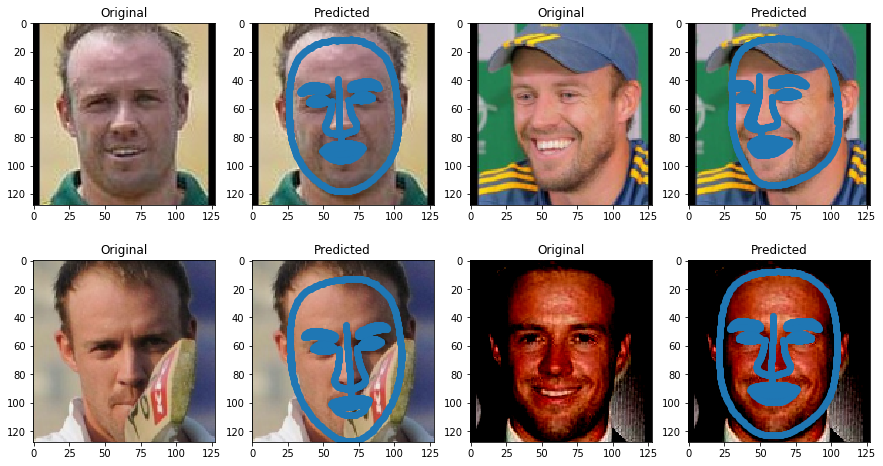

training...:   0%|          | 0/2462 [00:00<?, ?it/s]

Epoch 2----------------------------------------------


validation...: 100%|██████████| 616/616 [02:19<00:00,  4.41it/s]

Epoch # 2:	train loss:   3.2	val loss:   2.8


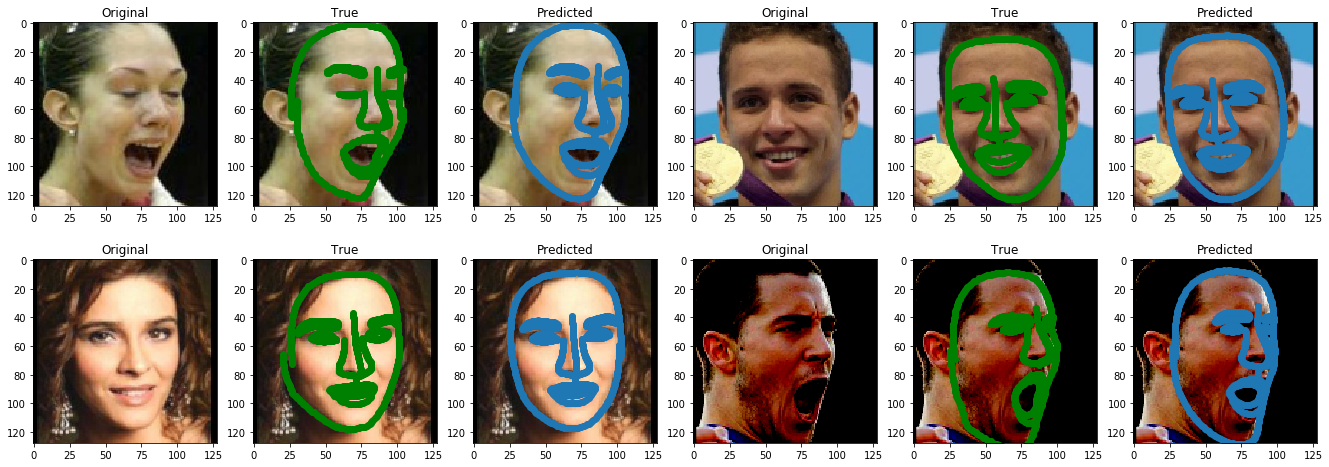

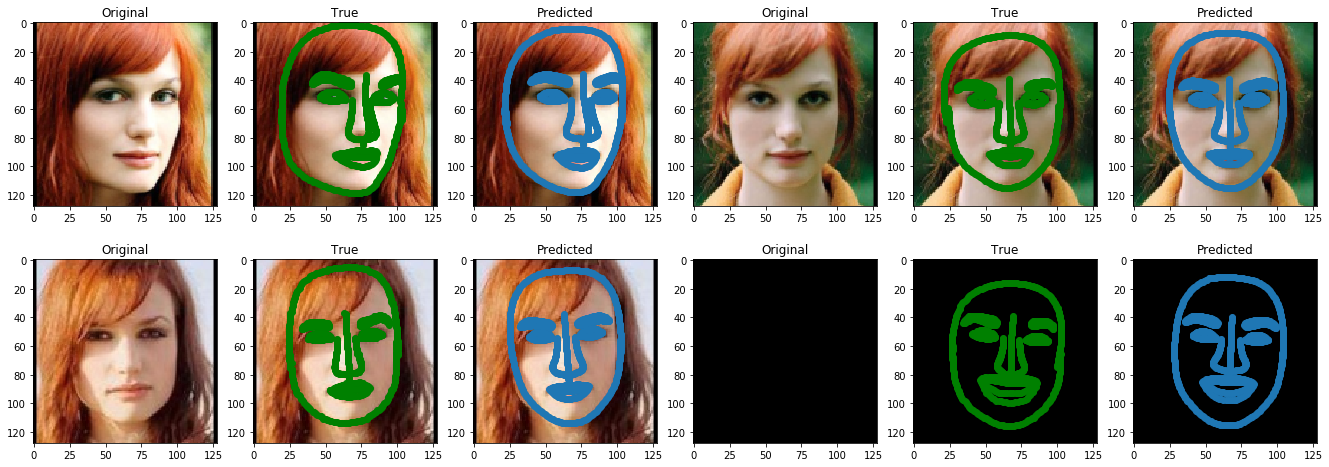

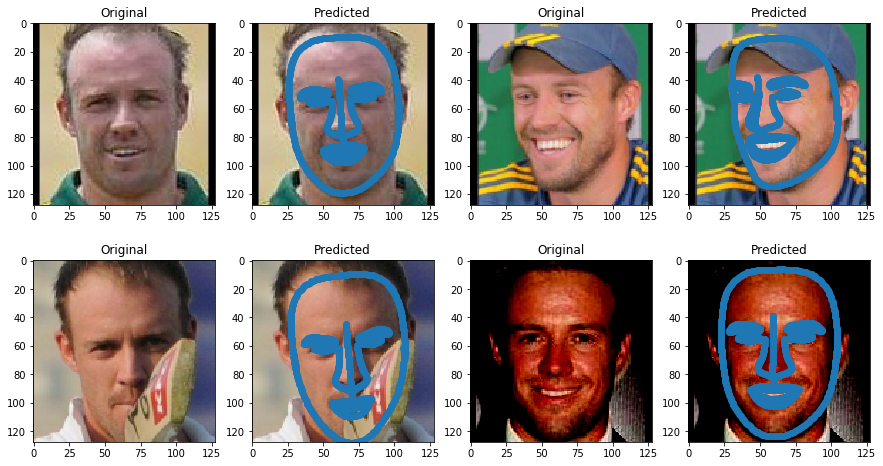

training...:   0%|          | 0/2462 [00:00<?, ?it/s]

Epoch 3----------------------------------------------


validation...: 100%|██████████| 616/616 [02:20<00:00,  4.38it/s]

Epoch # 3:	train loss:   2.7	val loss:   2.7


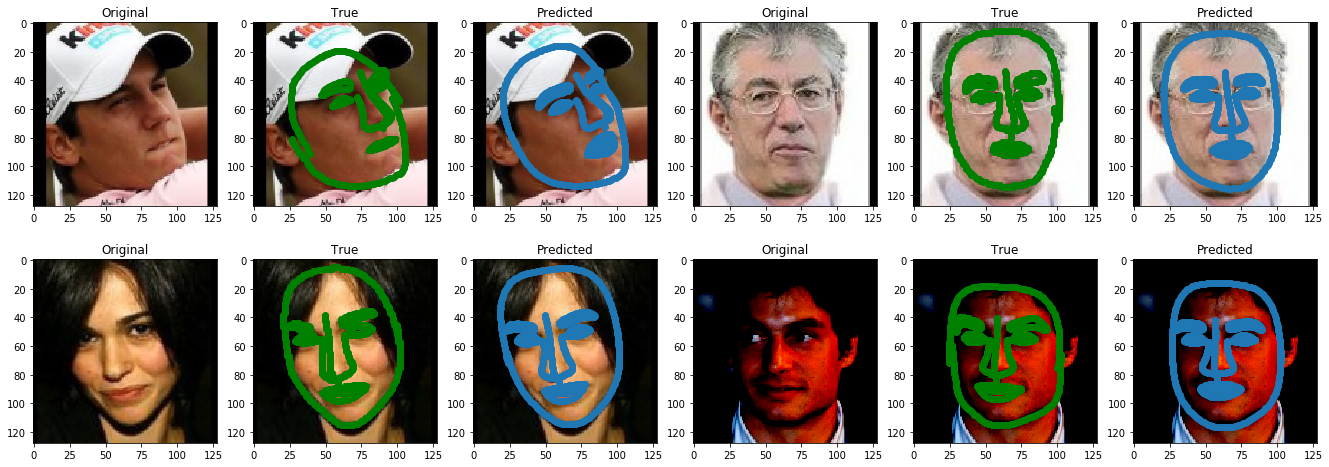

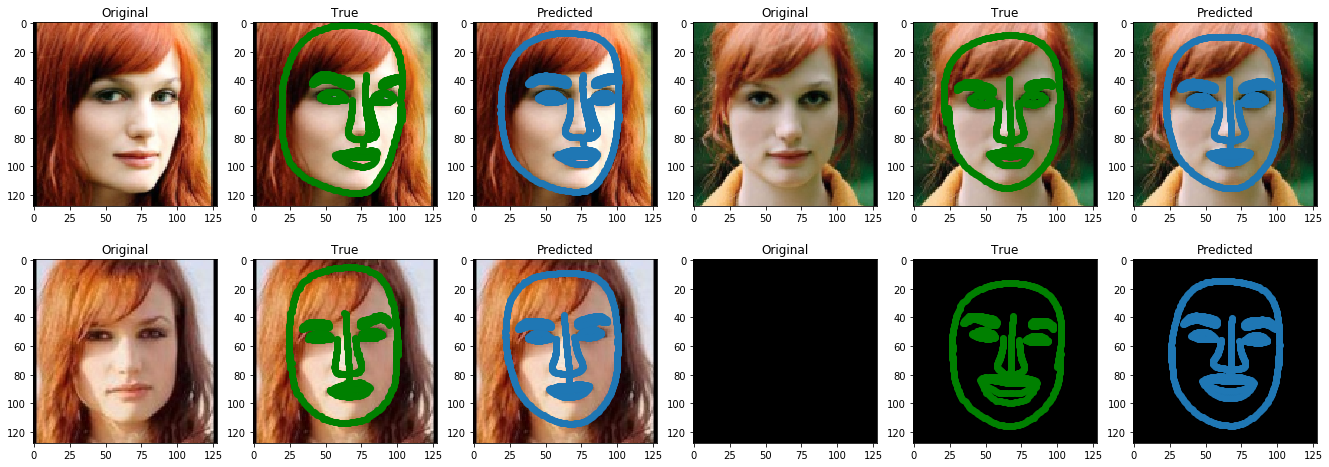

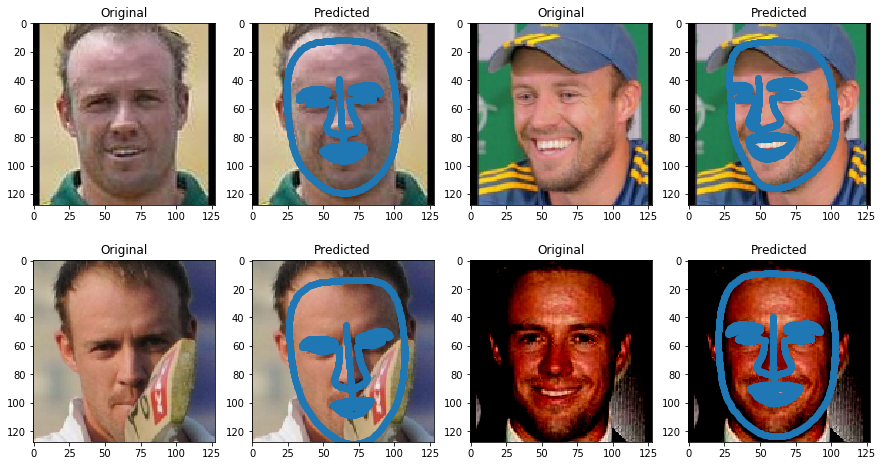

training...:   0%|          | 0/2462 [00:00<?, ?it/s]

Epoch 4----------------------------------------------


validation...: 100%|██████████| 616/616 [02:20<00:00,  4.39it/s]

Epoch # 4:	train loss:   2.4	val loss:   3.5


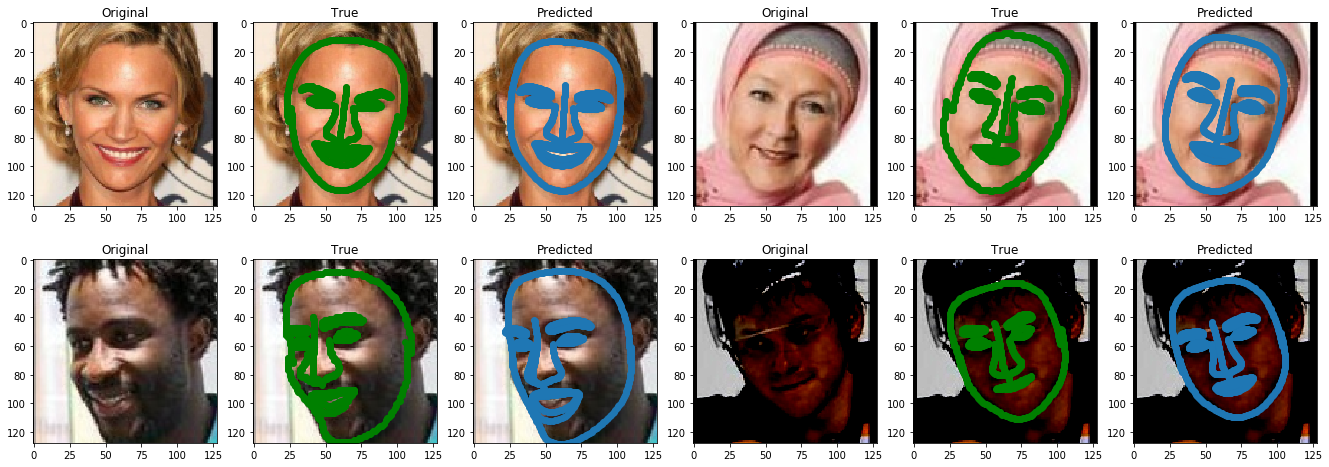

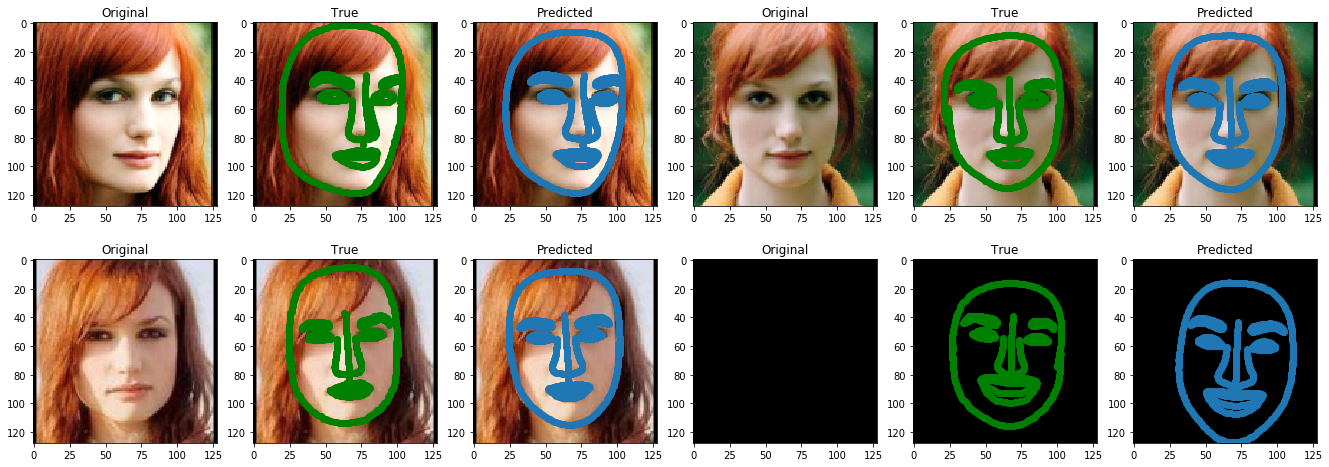

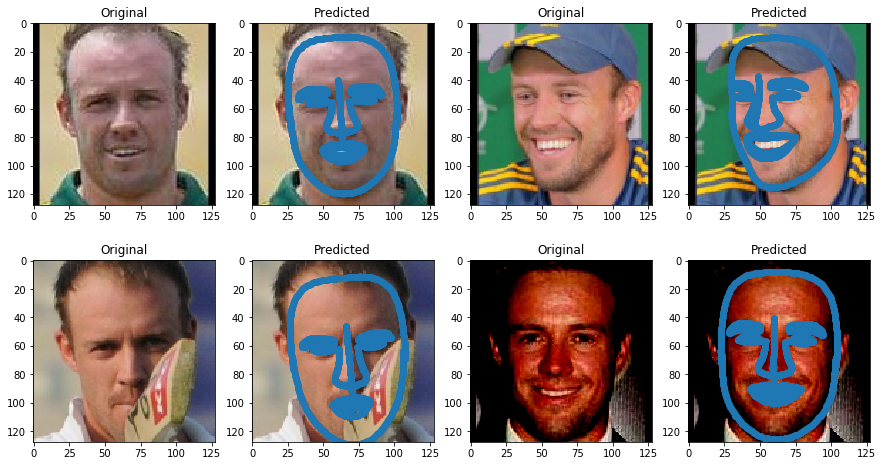

training...:   0%|          | 0/2462 [00:00<?, ?it/s]

Epoch 5----------------------------------------------


validation...: 100%|██████████| 616/616 [02:19<00:00,  4.42it/s]

Epoch # 5:	train loss:   2.2	val loss:   2.2


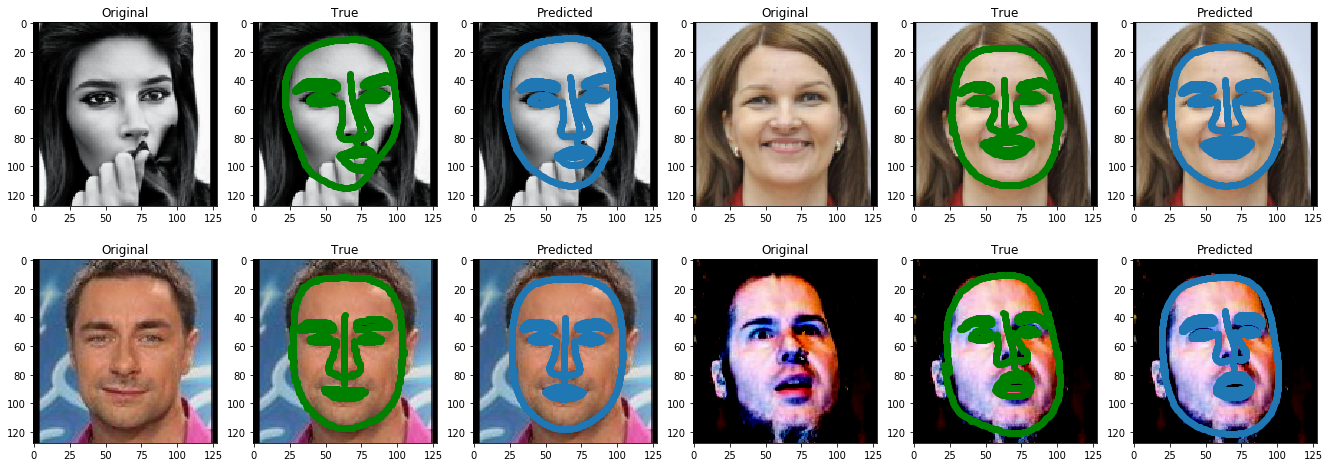

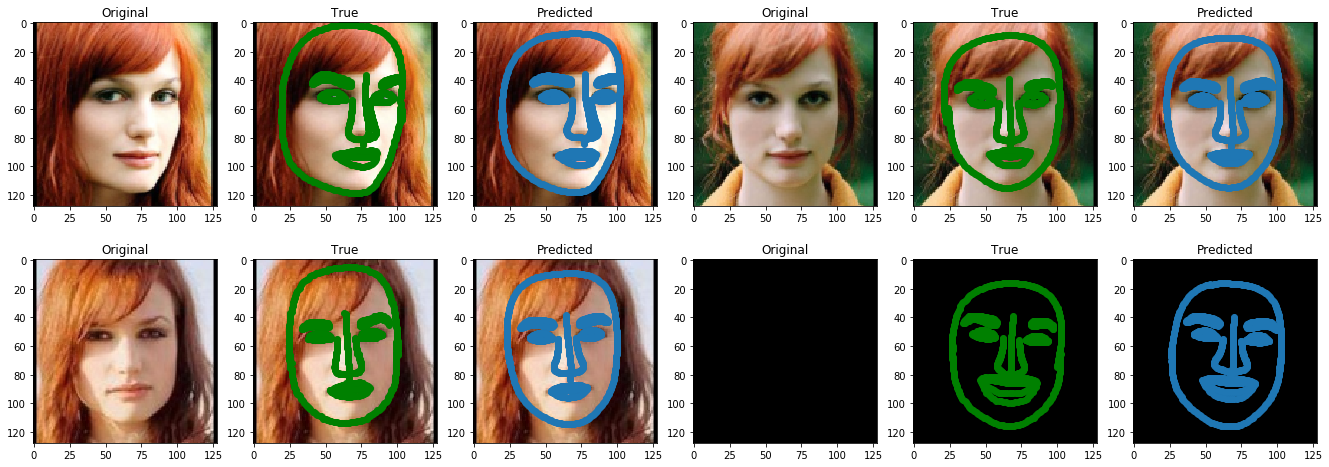

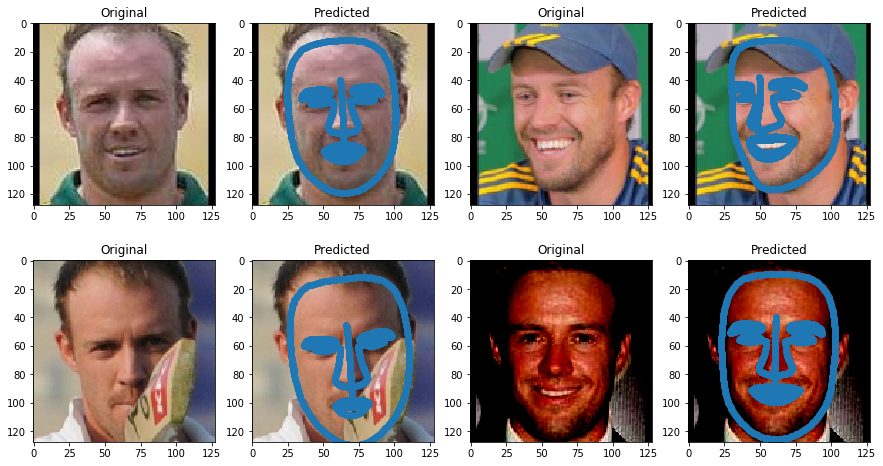

training...:   0%|          | 0/2462 [00:00<?, ?it/s]

Epoch 6----------------------------------------------


training...:  15%|█▍        | 358/2462 [04:48<28:04,  1.25it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes

KeyboardInterrupt: 

In [25]:
epochs = 20

print("Ready for training...")
best_val_loss = np.inf
for epoch in range(epochs):
    print(f'Epoch {epoch}----------------------------------------------')
    train_loss = train(model, train_dataloader, loss_fn, optimizer, device=device)
    val_loss = validate(model, val_dataloader, loss_fn, device=device)
    print("Epoch #{:2}:\ttrain loss: {:5.2}\tval loss: {:5.2}".format(epoch, train_loss, val_loss))

    plot_results(train_dataloader, model)
    plot_results(val_dataloader, model)
    plot_results(test_dataloader, model)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        with open(f"{name}_best.pth", "wb") as fp:
            torch.save(model.state_dict(), fp)
    
    with open(f"{name}_{epoch}_{round(val_loss,4)}.pth", "wb") as fp:
            torch.save(model.state_dict(), fp)

In [26]:
%%time
with open(f"{name}_best.pth", "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)
    
test_predictions = predict(model, test_dataloader, device)


test prediction...:  14%|█▍        | 112/780 [00:25<02:33,  4.37it/s]


test prediction...:  29%|██▊       | 224/780 [00:51<02:08,  4.34it/s]


test prediction...:  43%|████▎     | 336/780 [01:17<01:42,  4.32it/s]


test prediction...:  57%|█████▋    | 448/780 [01:43<01:15,  4.38it/s]


test prediction...:  72%|███████▏  | 560/780 [02:08<00:50,  4.38it/s]


test prediction...:  86%|████████▌ | 672/780 [02:34<00:24,  4.38it/s]


test prediction...: 100%|██████████| 780/780 [02:58<00:00,  4.36it/s]

CPU times: user 3min 1s, sys: 4.07 s, total: 3min 5s
Wall time: 2min 58s


In [27]:
%%time
TEST_PREDICTIONS_FILENAME = f"{name}_test_predictions.pkl"

with open(TEST_PREDICTIONS_FILENAME, "wb") as fp:
    pickle.dump({"image_names": test_dataset.image_names,
                     "landmarks": test_predictions}, fp)

CPU times: user 947 ms, sys: 2.35 s, total: 3.3 s
Wall time: 3.29 s


In [29]:
%%time
create_submission(DATA_PATH, test_predictions, f"{name}_submit.csv")

CPU times: user 21.1 s, sys: 80.1 ms, total: 21.2 s
Wall time: 21.2 s


In [30]:
NUM_IMAGES_TO_SHOW = 16
NUM_COLS = 4
NUM_ROWS = NUM_IMAGES_TO_SHOW // NUM_COLS + int(NUM_IMAGES_TO_SHOW % NUM_COLS != 0)

In [31]:
with open(TEST_PREDICTIONS_FILENAME, "rb") as fp:
    results = pickle.load(fp)
image_names = results["image_names"]
landmarks = results["landmarks"]

print("Images:", len(image_names))
print("Landmarks shape:", landmarks.shape)

if len(image_names) < NUM_IMAGES_TO_SHOW:
    raise RuntimeError(f"Choose less images to show, you have only {len(image_names)}")

Images: 99819
Landmarks shape: (99819, 971, 2)


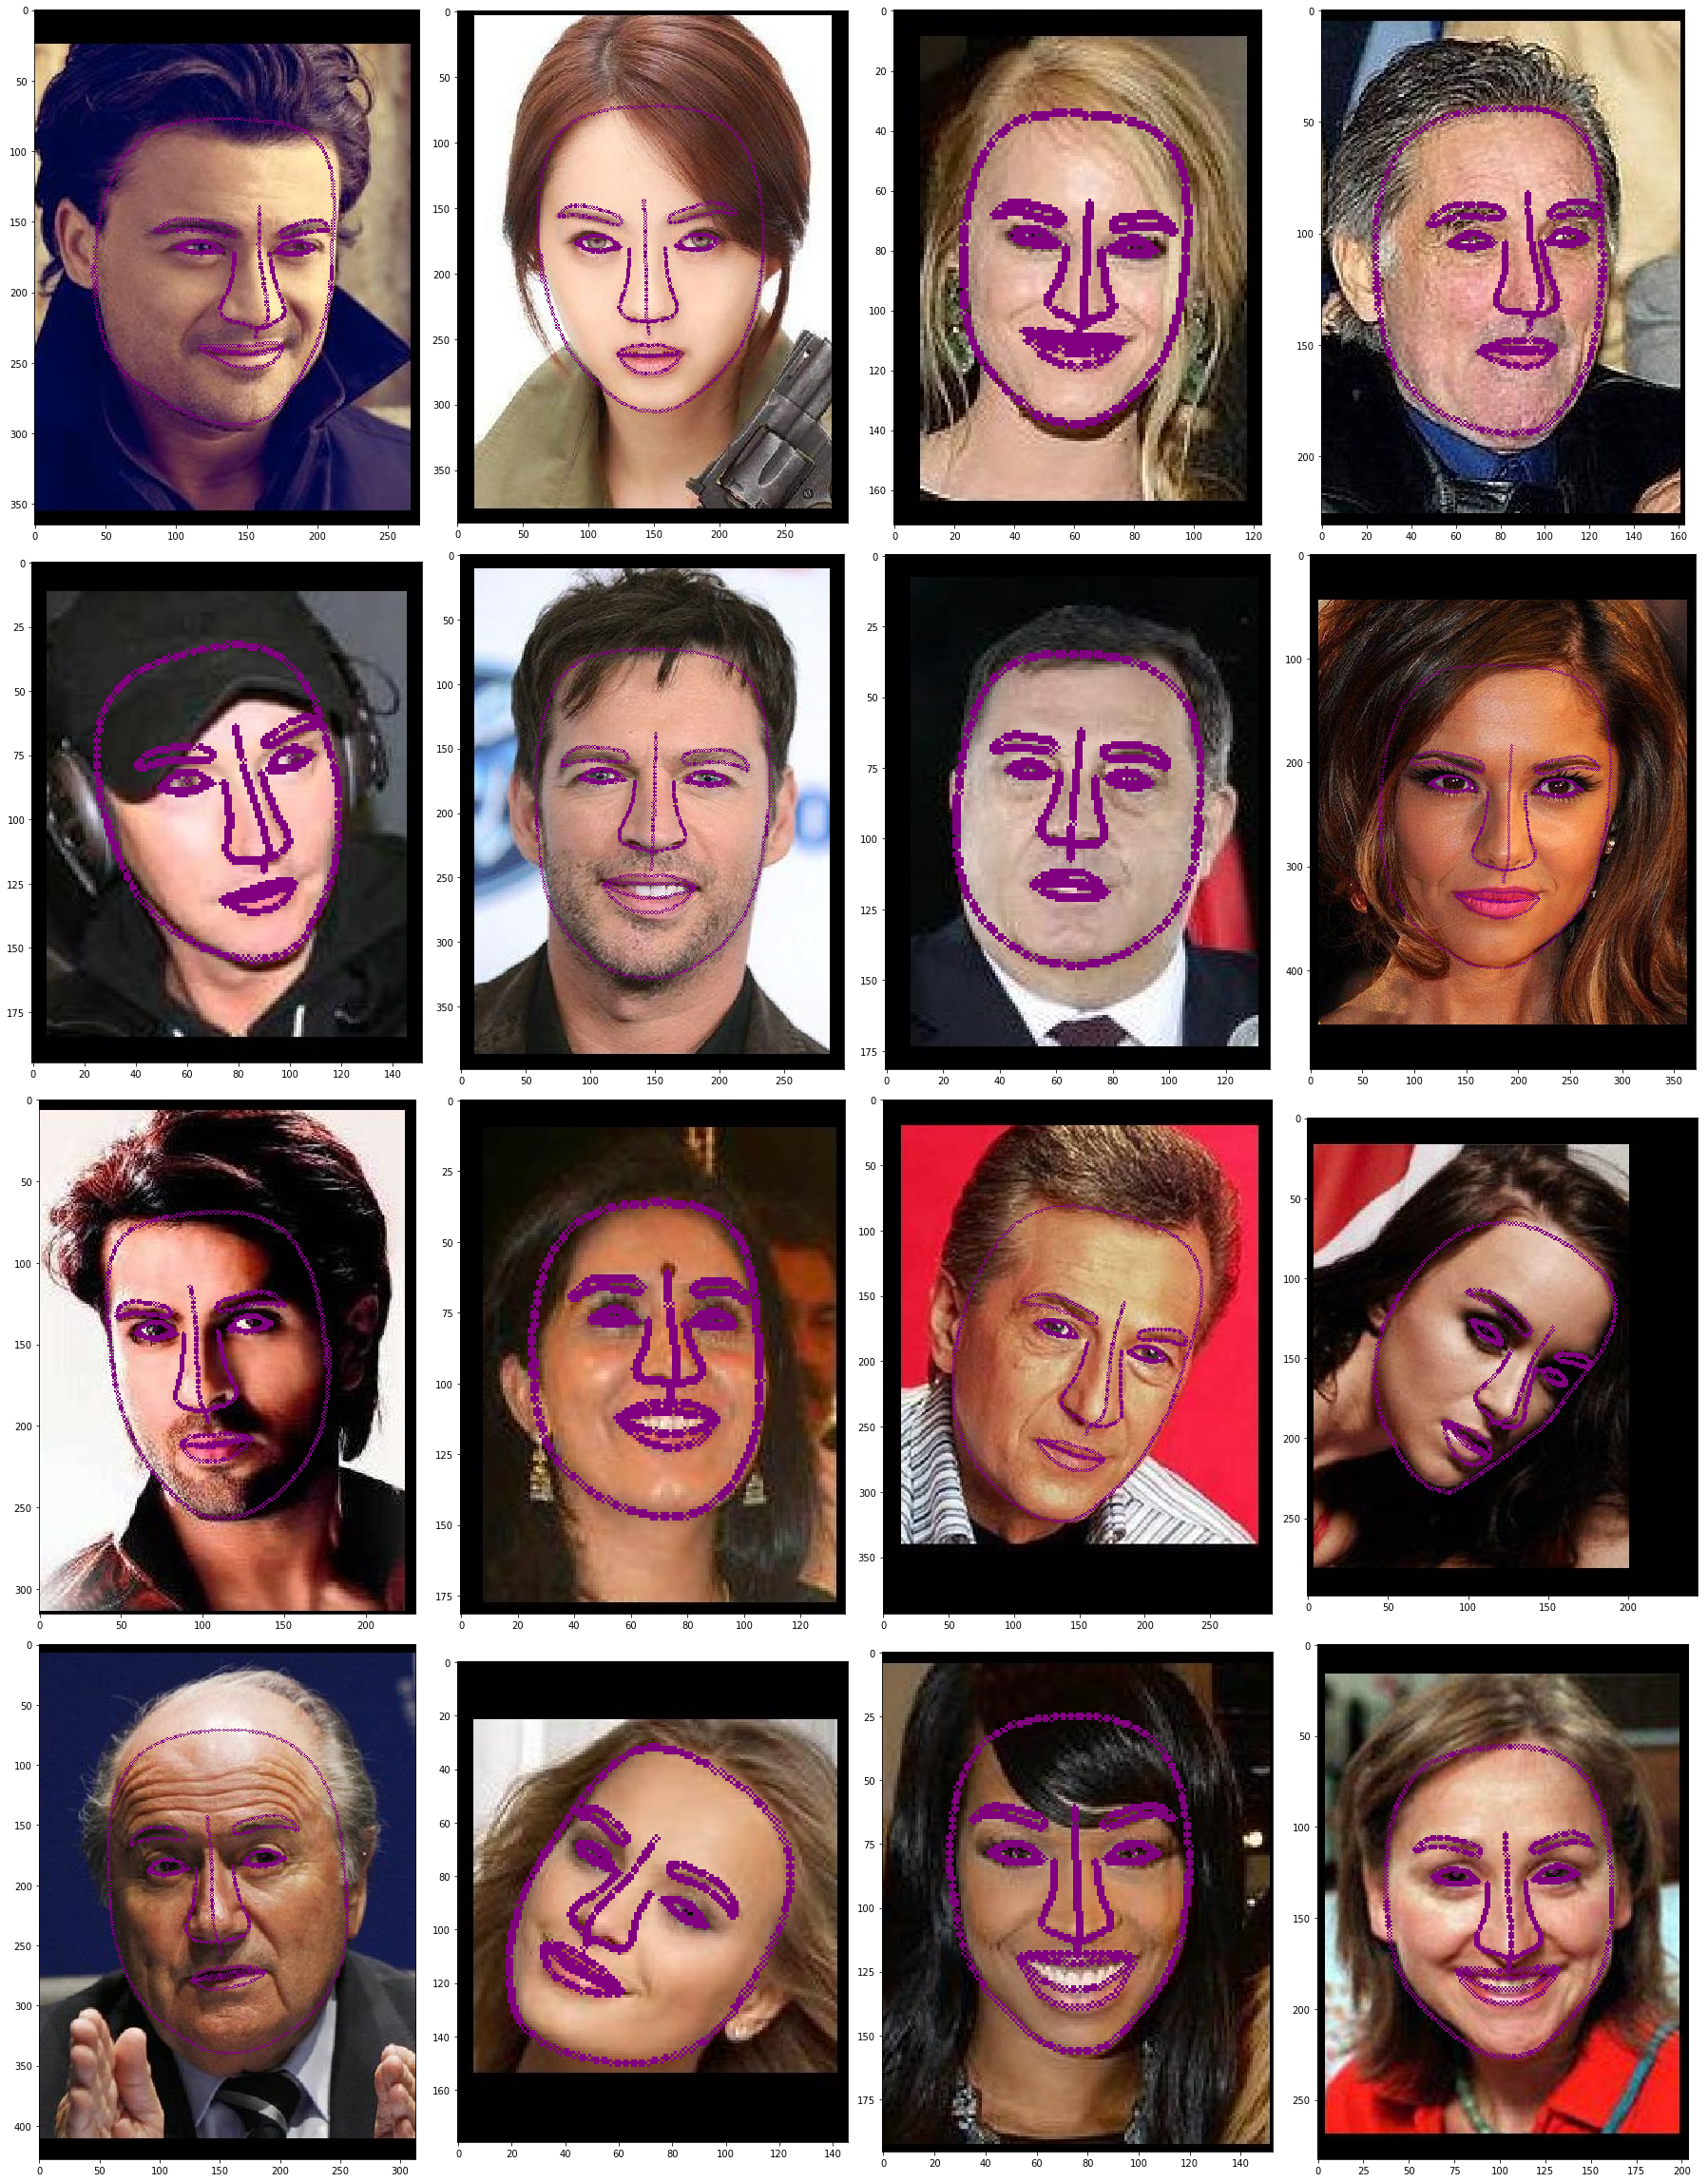

In [32]:
random_idxs = np.random.choice(len(image_names), size=min(NUM_IMAGES_TO_SHOW, len(image_names)), replace=False)

plt.figure(figsize=(25, NUM_ROWS * 8))
for i, idx in enumerate(random_idxs, 1):
    image = cv2.imread(image_names[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = draw_landmarks(image, landmarks[idx])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image)

plt.tight_layout()
plt.show()